[![PracticeProbs](https://d33wubrfki0l68.cloudfront.net/b6800cc830e3fd5a3a4c3d9cfb1137e6a4c15c77/ec467/assets/images/transparent-1.png)](https://www.practiceprobs.com/)

# [Pass Or Fail](https://www.practiceprobs.com/problemsets/pytorch/basic-models/pass-or-fail/)

A class of 100 students takes an exam. At the end of the exam, the students self-report the number of hours they studied 📚 for the exam and the amount of sleep 😴 they got the night before. Here's what the data looks like including the Pass/Fail exam results.

In [1]:
import numpy as np

# random number generator
rng = np.random.default_rng(123)

# data (72 passes / 28 fails)
passes_sleep = rng.normal(loc=8, scale=1, size=72)
passes_study = rng.normal(loc=12, scale=3, size=72)
fails_sleep = rng.normal(loc=6, scale=1.5, size=28)
fails_study = rng.normal(loc=6, scale=2, size=28)

## Plot

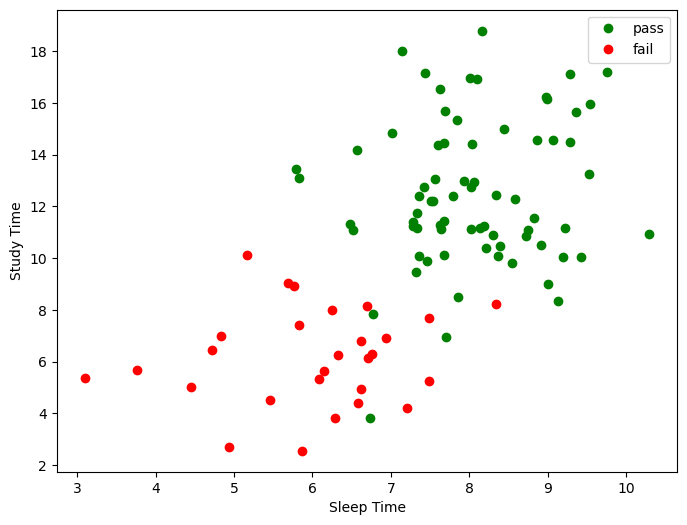

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(passes_sleep, passes_study, linestyle='None', marker='o', color='g', label='pass')
ax.plot(fails_sleep, fails_study, linestyle='None', marker='o', color='r', label='fail')
ax.set_xlabel('Sleep Time')
ax.set_ylabel('Study Time')
ax.legend()

**Design and fit a [logistic regression](https://en.wikipedia.org/wiki/Logistic_function) model to this data**. Be sure to subclass [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Here's some starter code.

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

**data 100 samples (72 passes / 28 fails)**
- passes_sleep = rng.normal(loc=8, scale=1, size=72)
- passes_study = rng.normal(loc=12, scale=3, size=72)
- fails_sleep = rng.normal(loc=6, scale=1.5, size=28)
- fails_study = rng.normal(loc=6, scale=2, size=28)

In [4]:
# collate data
sleep = np.concatenate([passes_sleep,fails_sleep])
study = np.concatenate([passes_study,fails_study])
X = np.column_stack([sleep,study]) # s samples x f features; feature columns, x0 - sleep, x1 - study
y = np.concatenate([[1] * len(passes_sleep), [0] * len(fails_sleep)]) # s samples
# standardize data
ss = StandardScaler()
X = ss.fit_transform(X)
# split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
skf_split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# check split
print(f"Train % pass: {(y_train_val == 0).sum()/0.8:.1f}, Test % pass: {(y_test == 0).sum()/0.2:.1f}")

Train % pass: 27.5, Test % pass: 30.0


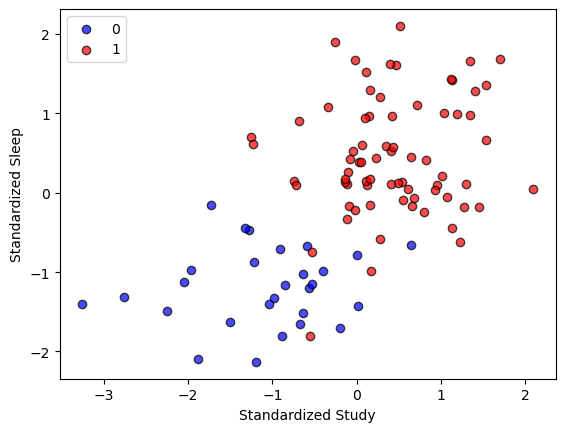

In [20]:
# re-plot data for visual sanity check of correct concatenations, labels, and normal/standard-ization - more important for complicated inputs
label_colors = {0:'blue', 1:'red'}
for label, color in label_colors.items():
    plt.scatter(X[y == label, 0],
                X[y == label, 1],
                label=f'{label}',
                color=color, alpha=0.7, edgecolor='k')
plt.ylabel('Standardized Sleep')
plt.xlabel('Standardized Study')
plt.legend()
plt.show()

In [6]:
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# set random seed for reproducibility
torch.manual_seed(0)

class LogisticRegression(nn.Module):
    def __init__(self, input_size) -> None:
        super().__init__()
        self.fc = nn.Linear(in_features=input_size, out_features=1, device=device)

    def forward(self, x):
        return self.fc(x) # Output raw logits

lr_model = LogisticRegression(X_train_val.shape[1])

In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.001)
num_epochs = 500
batch_size = 10

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

train_dataset = TensorDataset(torch.tensor(X_train_val, device=device, dtype=torch.float32),
                              torch.tensor(y_train_val, device=device, dtype=torch.float32).unsqueeze(1))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test, device=device, dtype=torch.float32),
                               torch.tensor(y_test, device=device, dtype=torch.float32).unsqueeze(1))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch: 100%|██████████| 500/500 [00:04<00:00, 100.25it/s]


Test Loss: 0.3200, Test Accuracy: 0.8500


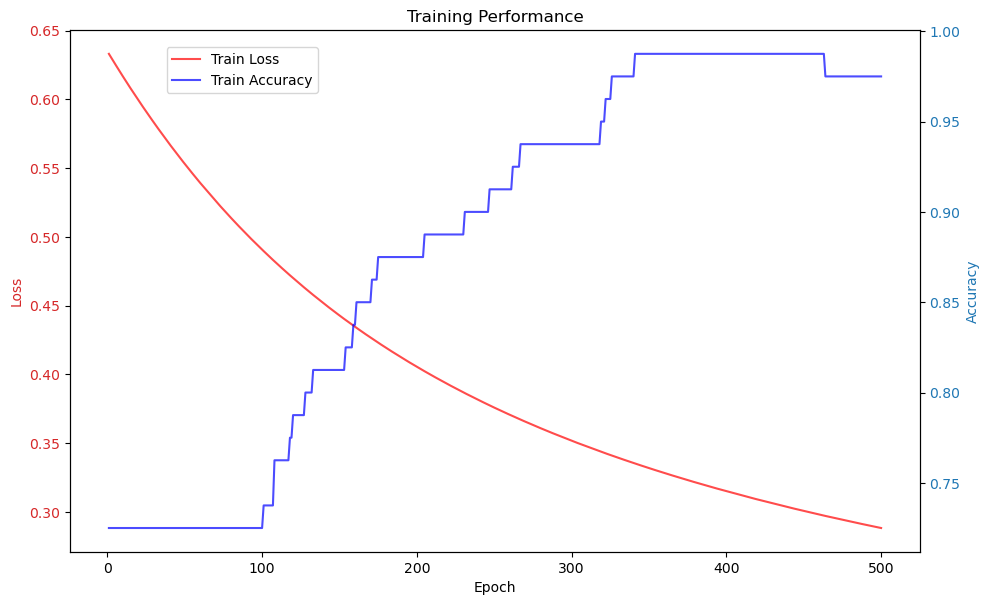

In [8]:
# --- Train all epochs
for epoch in tqdm(range(num_epochs), desc="Epoch"):
    lr_model.train()
    batch_losses = []
    batch_accuracies = []
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        pred = lr_model(batch_inputs)
        loss = criterion(pred, batch_labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        pred_labels = torch.round(torch.sigmoid(pred))
        batch_accuracies.append(accuracy_score(batch_labels.cpu().detach().numpy(),
                                               pred_labels.cpu().detach().numpy()))
    
    train_losses.append(np.mean(batch_losses))
    train_accuracies.append(np.mean(batch_accuracies))

# --- Test evaluation
lr_model.eval()
test_losses = []
test_accuracies = []

with torch.no_grad():
    for batch_inputs, batch_labels in test_dataloader:
        pred = lr_model(batch_inputs)
        loss = criterion(pred, batch_labels)

        test_losses.append(loss.item())
        pred_labels = torch.round(torch.sigmoid(pred))
        test_accuracies.append(accuracy_score(batch_labels.cpu().detach().numpy(),
                                                pred_labels.cpu().detach().numpy()))

avg_test_loss = np.mean(test_losses)
avg_test_accuracy = np.mean(test_accuracies)
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

# --- Plot training performance
epochs = range(1, len(train_losses) + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, 'r-', label='Train Loss', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_accuracies, 'b-', label='Train Accuracy', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Performance')
fig.legend(loc='upper right', bbox_to_anchor=(0.33, 0.95), bbox_transform=fig.transFigure)
plt.show()

## Bonus 1

Use your fitted model to make predictions on the following test data.

In [10]:
test_sleep = np.array([
    7.06, 7.19, 7.59, 8.84, 9.66, 9.72, 8.81,
    8.44, 5.66, 9.13, 8.04, 5.31, 7.07, 8.33, 7.83
])
test_study = np.array([
    19.89, 13.36, 12.7, 14.1, 14.19, 12.4, 10.88, 
    13.09, 7.88, 6.35, 4.89, 6.65, 3.67, 5.79, 8.09
])

In [15]:
X_inference = np.column_stack([test_sleep,test_study]) # sleep, study - order matters
ss = StandardScaler()
X_inference = ss.fit_transform(X_inference)
X_inference = torch.tensor(X_inference, dtype=torch.float32, device=device)

pred = lr_model(X_inference)
pred_labels = torch.round(torch.sigmoid(pred))
print(pred_labels)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)


## Bonus 2

Draw your fitted model's decision boundary onto the plot above.

---

In [28]:
# w0*x0 + w1*x1 + b = 0
# solve:
# x1 = - (w0*x0 + b) / w1  ---  becomes boundary in  study = f(sleep); x1 = f(x0)

w = lr_model.fc.weight.cpu().detach().numpy()[0]
b = lr_model.fc.bias.cpu().detach().numpy()[0]
x0_abscissa = np.linspace(X[:,0].min(), X[:,0].max(), 2)
x1_boundary = - ( w[0] * x0_abscissa + b ) / w[1]

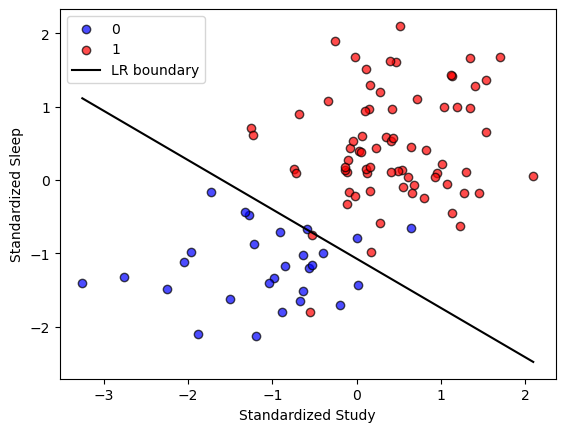

In [29]:
label_colors = {0:'blue', 1:'red'}
for label, color in label_colors.items():
    plt.scatter(X[y == label, 0],
                X[y == label, 1],
                label=f'{label}',
                color=color, alpha=0.7, edgecolor='k')
plt.plot(x0_abscissa, x1_boundary, color='black', label='LR boundary')
plt.ylabel('Standardized Sleep')
plt.xlabel('Standardized Study')
plt.legend()
plt.show()

## [See our solution!](https://www.practiceprobs.com/problemsets/pytorch/basic-models/pass-or-fail/solution/)